In [19]:
# Import modules and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn import manifold
from sklearn import cluster

from sklearn import set_config
from sklearn.metrics import silhouette_score


data = pd.read_csv('bank.csv')

In [2]:
data.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [3]:
data.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [4]:
# Pipelines
age_variables = ['age']
age_transform = Pipeline(steps = [("imputer", SimpleImputer(strategy="median")),
                                     ("distribution_transform", FunctionTransformer(func=np.log))])

numerical_variables = ['balance','duration','previous']
numerical_transform = Pipeline(steps = [('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [5]:
categorical_variables = ['job','contact','marital','default','housing','loan','campaign','subscribed']
category_transform = Pipeline(steps = [("imputer", SimpleImputer(strategy="most_frequent")),
                                      ('onehotencode', OneHotEncoder(handle_unknown='ignore'))])

education_category = ['education']
education_order = ['primary', 'secondary','tertiary']
education_transform = Pipeline(steps = [("imputer", SimpleImputer(strategy="most_frequent")),
                                      ('ordinal', OrdinalEncoder(categories=[education_order]))])

In [6]:
outcome_category = ['poutcome']
outcome_transform = Pipeline(steps = [("imputer", SimpleImputer(strategy="constant", fill_value="No Previous Outcome")),
                                      ('outcomeencode', OneHotEncoder(handle_unknown='ignore'))])

In [7]:
# Month Text to Numeric Replacement:
month_scale_mapper = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}

data['month'] = data['month'].replace(month_scale_mapper)

cyclical_varaibles = ['day','month']

data['month'] = pd.to_numeric(data['month'], errors='coerce')
data['day'] = pd.to_numeric(data['day'], errors='coerce')

# Day Sine and Cosine Transformations
data['sine_day'] = np.sin(2 * np.pi * data['day'] / 31)
data['cosine_day'] = np.cos(2 * np.pi * data['day'] / 31)

# Month Sine and Cosine Transformations
data['sine_month'] = np.sin(2 * np.pi * data['month'] / 12)
data['cosine_month'] = np.cos(2 * np.pi * data['month'] / 12)

In [8]:
# Combine All Datas Preprocessing steps:
preprocessing_pipeline = ColumnTransformer(
    transformers = [
        ('numerical',numerical_transform, numerical_variables),    # preprocessing of numerical varaibles
        ("categorical", category_transform, categorical_variables),
        ('ordinal', education_transform, education_category),# preprocessing of categorical variables
        ("outcome", outcome_transform, outcome_category),
        ("age", age_transform, age_variables)
    ],
    remainder='passthrough'
)

# Task 2

In [9]:
# K Means Clustering
k = 3

pipe = Pipeline(steps=[
    ('preprocess', preprocessing_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=100))
])

In [10]:
# cluster model
cluster_model = pipe.fit(data)

In [11]:
# Preprocessing Pipeline Utilised
preprocessed_data = cluster_model['preprocess'].transform(data)
preprocessed_data

set_config(display='diagram')
display(cluster_model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['balance', 'duration',
                                                   'previous']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencode',
                                                                   OneHotEncoder(handle_unkno...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='No '
                                                                                            'Previous '
                                                                                            'Outcome',
                                                                                 strategy='constant')),
                                                                  ('outcomeencode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['poutcome']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('distribution_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>))]),
                                                  ['age'])])),
                ('kMeans', KMeans(max_iter=100, n_clusters=3, n_init=10))])

In [17]:
colors = np.array(['green', 'blue', 'red', 'yellow', 'black', 'purple', 'orange'])

def clusterplot(points, labels, centers, title):
    ''' Create Cluster Plot'''
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))
    
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    plt.title(title)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')


In [14]:
kmeans_centers = pipe.named_steps['kMeans'].cluster_centers_

#print("Processed data shape:", processed_data.shape)
#print("Cluster centers shape:", pipe.named_steps['kMeans'].cluster_centers_.shape)

center_data = np.vstack([preprocessed_data, kmeans_centers])
points = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(center_data)

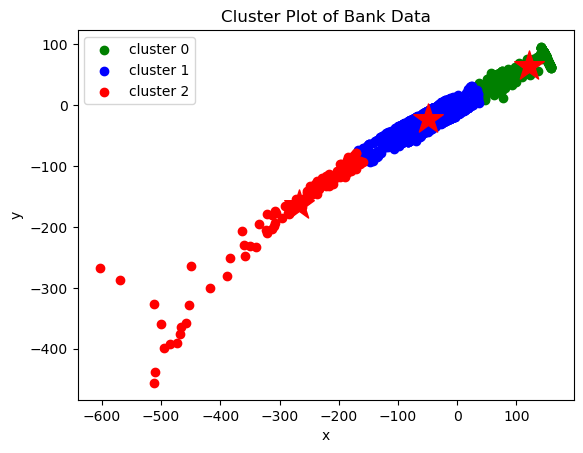

In [18]:
clusterplot(points[:-k,:], 
                       labels=cluster_model['kMeans'].labels_, 
                       centers=points[-k:,:], 
                       title='Cluster Plot of Bank Data')

In [ ]:

preprocess_pipe = Pipeline([
    ('preprocess', preprocessing_pipeline)
])
processed_data = preprocess_pipe.fit_transform(data)

print("Processed data shape:", processed_data.shape)
print("Cluster centers shape:", pipe.named_steps['kMeans'].cluster_centers_.shape)